In [ ]:
!pip install radis

**Loading Dependencies**

In [1]:
import matplotlib.pyplot as plt
from radis import plot_diff, SpectrumFactory, get_residual
from publib import set_style, fix_style
import numpy as np


**Setting up parameters**

In [2]:
SAVE=True  # save figs
# Computation parameters
wmin = 2000
wmax = 10000
dv = 0.005
T = 3000.0 #K
p = 0.1 #bar
broadening_max_width=10    # slineshape broadening width, ext



**Defining Spectrum Factory Object**

In [3]:
#%% Calculate reference
sf = SpectrumFactory(wavenum_min=wmin, wavenum_max=wmax, 
                  pressure=p,
                  wstep=dv,
                  broadening_max_width=broadening_max_width, 
                  molecule="OH",
                  cutoff=0, # 1e-27,
                  verbose=2,
                  )


**Downloading/Loading Database from hitran.**
**If already downloaded then skip this** 

In [4]:
# Fetching data from HITEMP Database and loading in spectrum factory
sf.fetch_databank('hitemp',load_energies=False)


Using existing database HITEMP-OH
parse_local_quanta not implemented for molecules of HITRAN group 6
parse_global_quanta not implemented for molecules of HITRAN class 3
The following columns had the `object` format and were removed: ['globu', 'globl', 'locu', 'locl', 'ierr', 'iref', 'lmix']
... Fetching molecular parameters for all transitions
... Fetched molecular params in 0.00s
HAPI version: 1.1.2.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
    

**Defining variabes to store spectrum**

In [5]:
#  Defining variabes to store spectrum
spectra_default = {}
spectra_DLM = {}
spectra_DLM_opt = {}

Nlines_target = [1e1, 1e2, 1e3, 1e4, 1e5]  # Number of lines in the dataframe df0
Nlines = []


**Function to take complement of an array of indexes in a range**

In [6]:
# Finds complement of the lines to drop
def find_missing(lst, N):
    start = 0
    end = N-1
    return sorted(set(range(start, end + 1)).difference(lst))

Running the eq_spectrum for all the 3 methods (**None, simple, min-RMS**) For different number of lines

In [ ]:
for Ntarget in Nlines_target:
    
    # Load HITEMP database for this species/range (433984 rows)
    sf.load_databank('HITEMP-OH',load_energies=False)

    # Reduce number of lines to approximately Nlines:
    rows = np.arange(0,len(sf.df0),max(1,int(len(sf.df0)//Ntarget)))
    # Complements the array
    rows = find_missing(rows,len(sf.df0))
    rows = sf.df0.index[rows]
    # Drops the array to use
    sf.df0.drop(rows, inplace=True)
    #sf.df0 = sf.df0[::max(1,int(len(sf.df0)//Ntarget))]
    N = len(sf.df0)
    Nlines.append(N)
    
    #%% Calculate normal

    sf.params['optimization'] = None
    sf.params['broadening_method'] = 'voigt'
    sf.misc['chunksize'] = 1e7
    s_none = sf.eq_spectrum(T)
    s_none.name = 'Default ({0:.1f}s)'.format(s_none.conditions['calculation_time'])
    spectra_default[N] = s_none

    # %% Calculate DLM
    
    sf.params['optimization'] = "simple"
    sf.params['broadening_method'] = 'fft'
    s_dlm = sf.eq_spectrum(T)
    s_dlm.name = 'New method {0}'.format(s_dlm.conditions['calculation_time'])
    spectra_DLM[N] = s_dlm

    # %% Calculate DLM (optimized)
    
    sf.params['optimization'] = "min-RMS"
    sf.params['broadening_method'] = 'fft'
    s_dlm_opt = sf.eq_spectrum(T)
    s_dlm_opt.name = 'DLM ({0:.1f}s)'.format(s_dlm_opt.conditions['calculation_time'])
    spectra_DLM_opt[N] = s_dlm_opt


**Checking the performance difference between different Methods and Number of lines (N_lines vs Computational Time)**

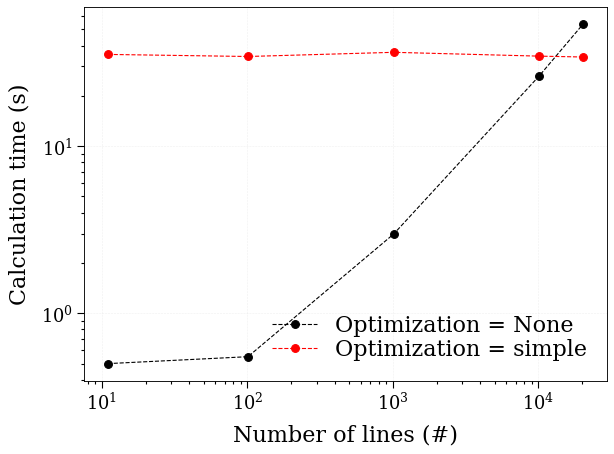

In [8]:
#%% Compare performance (opt)
set_style('origin')
plt.figure()
plt.plot(Nlines, [spectra_default[N].conditions['calculation_time'] for N in Nlines], '--ok', label = "Optimization = None" )
plt.plot(Nlines, [spectra_DLM[N].conditions['calculation_time'] for N in Nlines], '--or', label = "Optimization = simple")
plt.xlabel('Number of lines (#)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Calculation time (s)')
plt.legend()
fix_style('origin')

**Comparison plots between different method**

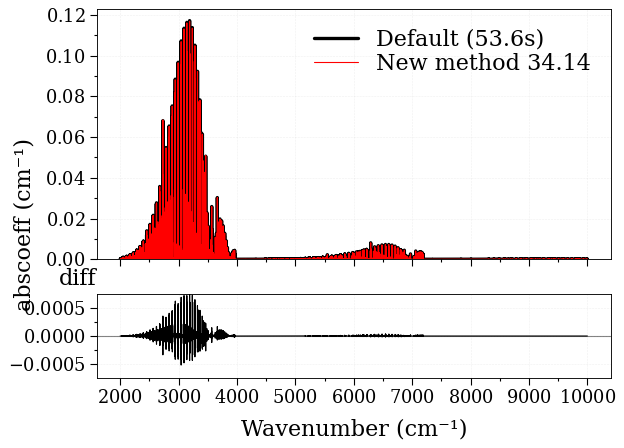

<Figure size 640x480 with 0 Axes>

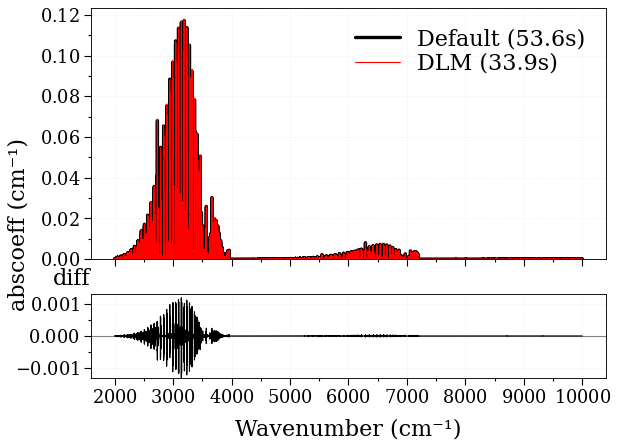

<Figure size 640x480 with 0 Axes>

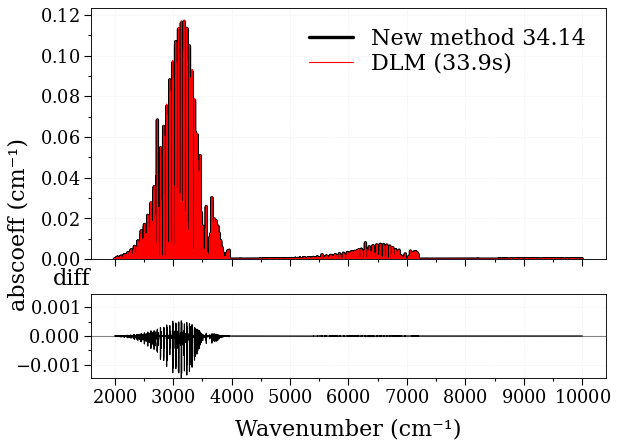

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.





>>>>>> for Article

11 lines
noDLM : 0.5s 	 --> 3.5e+07 lines.points/s
DLM : 34.7s 	 --> 5.1e+05 lines.points/s

101 lines
noDLM : 0.6s 	 --> 2.9e+08 lines.points/s
DLM : 34.4s 	 --> 4.7e+06 lines.points/s

1014 lines
noDLM : 3.0s 	 --> 5.4e+08 lines.points/s
DLM : 34.4s 	 --> 4.7e+07 lines.points/s

10131 lines
noDLM : 26.3s 	 --> 6.2e+08 lines.points/s
DLM : 34.2s 	 --> 4.7e+08 lines.points/s

20262 lines
noDLM : 53.6s 	 --> 6.1e+08 lines.points/s
DLM : 33.9s 	 --> 9.6e+08 lines.points/s


<Figure size 640x480 with 0 Axes>

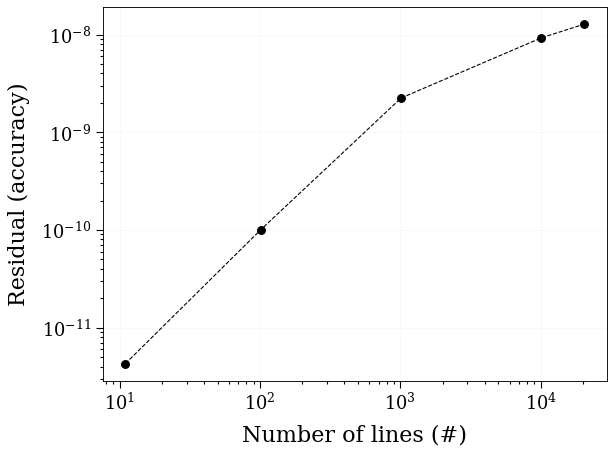

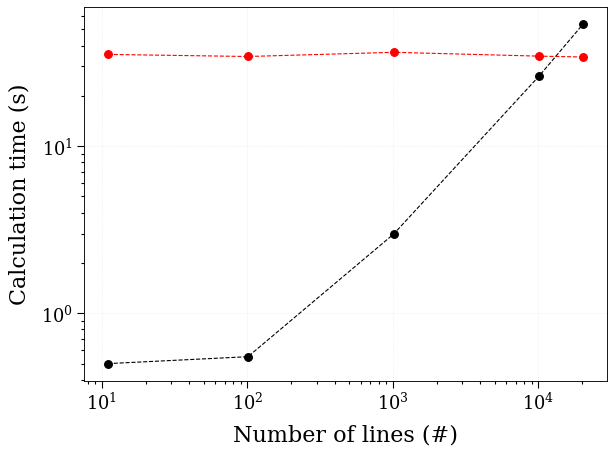

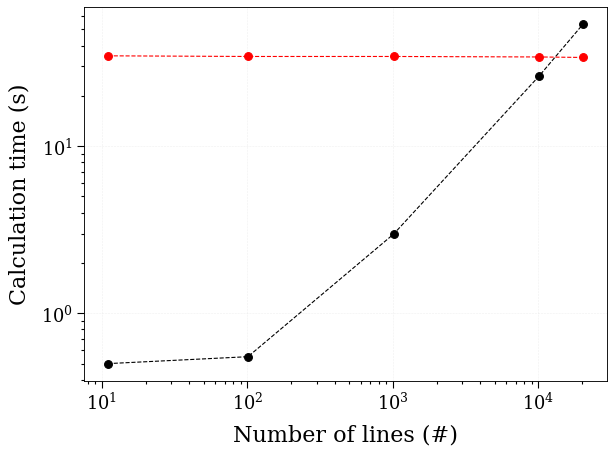

In [9]:
# %% Plot last spectra
plot_diff(spectra_default[N], spectra_DLM[N], 'abscoeff')
if SAVE: plt.savefig('/OH Benchmark 1e1 to 1e5/fig6b_DLMpaper_benchmark_Nlines_2spectra.png') 
if SAVE: plt.savefig('/OH Benchmark 1e1 to 1e5/fig6b_DLMpaper_benchmark_Nlines_2spectra.pdf') 

# %% Plot last spectra (opt)
plot_diff(spectra_default[N], spectra_DLM_opt[N], 'abscoeff')
if SAVE: plt.savefig('/OH Benchmark 1e1 to 1e5/fig6_DLMpaper_benchmark_Nlines_2spectra_minRMS.png') 
if SAVE: plt.savefig('/OH Benchmark 1e1 to 1e5/fig6_DLMpaper_benchmark_Nlines_2spectra_minRMS.pdf') 

# %% Plot last spectra
plot_diff(spectra_DLM[N], spectra_DLM_opt[N], 'abscoeff')
if SAVE: plt.savefig('/OH Benchmark 1e1 to 1e5/DLMpaper_benchmark_Nlines_2spectra_simple_vs_minRMS.png') 
if SAVE: plt.savefig('/OH Benchmark 1e1 to 1e5/DLMpaper_benchmark_Nlines_2spectra_simple_vs_minRMS.pdf') 

#%% Compare residual
set_style('origin')
plt.figure()
plt.plot(Nlines, [get_residual(spectra_default[N], spectra_DLM_opt[N], 'abscoeff')
                  for N in Nlines], '--ok')
plt.xlabel('Number of lines (#)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Residual (accuracy)')
plt.legend()
fix_style('origin')
if SAVE: plt.savefig('/OH Benchmark 1e1 to 1e5/DLMpaper_benchmark_Nlines_residual.png')
if SAVE: plt.savefig('/OH Benchmark 1e1 to 1e5/DLMpaper_benchmark_Nlines_residual.pdf')


#%% Compare performance (simple)
set_style('origin')
plt.figure()
plt.plot(Nlines, [spectra_default[N].conditions['calculation_time'] for N in Nlines], '--ok')
plt.plot(Nlines, [spectra_DLM[N].conditions['calculation_time'] for N in Nlines], '--or')
plt.xlabel('Number of lines (#)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Calculation time (s)')
plt.legend()
fix_style('origin')
if SAVE: plt.savefig('/OH Benchmark 1e1 to 1e5/DLMpaper_benchmark_Nlines_time.png')
if SAVE: plt.savefig('/OH Benchmark 1e1 to 1e5/DLMpaper_benchmark_Nlines_time.pdf')


#%% Compare performance (opt)
set_style('origin')
plt.figure()
plt.plot(Nlines, [spectra_default[N].conditions['calculation_time'] for N in Nlines], '--ok')
plt.plot(Nlines, [spectra_DLM_opt[N].conditions['calculation_time'] for N in Nlines], '--or')
plt.xlabel('Number of lines (#)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Calculation time (s)')
plt.legend()
fix_style('origin')
if SAVE: plt.savefig('/OH Benchmark 1e1 to 1e5/fig5_DLMpaper_benchmark_Nlines_time_minRMS.png')
if SAVE: plt.savefig('/OH Benchmark 1e1 to 1e5/fig5_DLMpaper_benchmark_Nlines_time_minRMS.pdf')

#%% Data for article

print('\n'*3+'>>>>>> for Article')
for N in Nlines:
    print('\n{0} lines'.format(spectra_default[N].conditions['lines_calculated']))
    print('noDLM : {0:.1f}s \t --> {1:.1e} lines.points/s'.format(
            spectra_default[N].conditions['calculation_time'],
            (len(spectra_default[N].get_wavenumber())*spectra_default[N].conditions['lines_calculated']/
                    spectra_default[N].conditions['calculation_time']),
            ))
    print('DLM : {0:.1f}s \t --> {1:.1e} lines.points/s'.format(
            spectra_DLM_opt[N].conditions['calculation_time'],
            (len(spectra_DLM_opt[N].get_wavenumber())*spectra_DLM[N].conditions['lines_calculated']/
                    spectra_DLM_opt[N].conditions['calculation_time']),
            ))